# Analysis and Visualization of Complex Agro-Environmental Data
---
## Interactive visualization in python with `Bokeh`, `Plotly`, `Dash` and `Altair`

### 1. Bokeh

`Bokeh` is a Python's module for interactive da visualizations. The plots are created by stacking layers on top of each other. The first step is to create an empty figure, to which elements are added in layers. These elements are known as glyphs, which can be anything from lines to bars to circles. Attached to each glyph are properties such as color, size and coordinates.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.plotting import figure, output_file, save, show

#### 1.1 Data preparation

##### Download 2 datasets: (1) CO2 emissions per person per year per country and (2) GDP per year per country:

In [38]:
# URL for the CO2 emissions dataset
url_co2 = 'https://raw.githubusercontent.com/TrainingByPackt/Interactive-Data-Visualization-with-Python/master/datasets/co2.csv'
# Load the CO2 emissions data into a DataFrame
co2 = pd.read_csv(url_co2)

# URL for the Gapminder dataset
url_gm = 'https://raw.githubusercontent.com/TrainingByPackt/Interactive-Data-Visualization-with-Python/master/datasets/gapminder.csv'
# Load the Gapminder data into a DataFrame
gm = pd.read_csv(url_gm)

# Display the first few rows of the CO2 emissions DataFrame to inspect its structure
co2.head()

# Display the first few rows of the Gapminder DataFrame to inspect its structure
gm.head()

,Country,Year,fertility,life,population,child_mortality,gdp,region
0,Afghanistan,1964,7.671,33.639,10474903.0,339.7,1182.0,South Asia
1,Afghanistan,1965,7.671,34.152,10697983.0,334.1,1182.0,South Asia
2,Afghanistan,1966,7.671,34.662,10927724.0,328.7,1168.0,South Asia
3,Afghanistan,1967,7.671,35.170,11163656.0,323.3,1173.0,South Asia
4,Afghanistan,1968,7.671,35.674,11411022.0,318.1,1187.0,South Asia


##### Prepare the dataset

Transform the dataset - intersect datasets

In [39]:
# Extract 'Country' and 'region' columns from gm and drop duplicate rows to get unique country-region pairs
df_gm = gm[['Country', 'region']].drop_duplicates()

# Merge the CO2 dataset with country-region data from gm on country names (inner join keeps only matching countries)
df_w_regions = pd.merge(
    co2,               # left DataFrame (CO2 data)
    df_gm,             # right DataFrame (country-region pairs)
    left_on='country', # merge key in co2 DataFrame
    right_on='Country',# merge key in gm DataFrame
    how='inner'        # inner join to keep only countries present in both datasets
)

# Drop the duplicate 'Country' column after merge, since 'country' is retained
df_w_regions = df_w_regions.drop('Country', axis='columns')

# Display the first few rows of the merged DataFrame to verify merging
df_w_regions.head()

,country,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,region
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0637,0.0854,0.154,0.242,0.294,0.412,0.35,0.316,0.299,South Asia
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.2800,1.3000,1.460,1.480,1.560,1.790,1.68,1.730,1.960,Europe & Central Asia
2,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.9900,3.1900,3.160,3.420,3.300,3.290,3.46,3.510,3.720,Middle East & North Africa
3,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.1000,1.2000,1.180,1.230,1.240,1.250,1.33,1.250,1.290,Sub-Saharan Africa
4,Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.9100,5.1400,5.190,5.450,5.540,5.360,5.42,5.360,5.380,America


Transform the dataset - stack by year

In [40]:
# Reshape the DataFrame from wide format to long format, keeping 'country' and 'region' as identifier variables
new_co2 = pd.melt(
    df_w_regions,            # DataFrame to reshape
    id_vars=['country', 'region']  # columns to keep as identifiers
)

# Display the reshaped DataFrame (long format with year and CO2 emission values)
new_co2

# Rename the columns to meaningful names: 'year' for variable, 'co2' for values
columns = ['country', 'region', 'year', 'co2'] 
new_co2.columns = columns

# Display the first few rows of the renamed DataFrame
new_co2.head()

# Filter the data to only include records from 1964 onwards (convert 'year' to integer for comparison)
df_co2 = new_co2[new_co2['year'].astype('int64') > 1963]

# Sort the filtered DataFrame first by 'country', then by 'year' for proper ordering
df_co2 = df_co2.sort_values(by=['country', 'year'])

# Convert 'year' column to integer type explicitly for consistency
df_co2['year'] = df_co2['year'].astype('int64')

# Display the cleaned and sorted CO2 DataFrame
df_co2.head()

,country,region,year,co2
28372,Afghanistan,South Asia,1964,0.0863
28545,Afghanistan,South Asia,1965,0.1010
28718,Afghanistan,South Asia,1966,0.1080
28891,Afghanistan,South Asia,1967,0.1240
29064,Afghanistan,South Asia,1968,0.1160


Create similar table for GDP per year per country

In [41]:
# Extract relevant columns for GDP data from gm DataFrame
df_gdp = gm[['Country', 'Year', 'gdp']]

# Rename columns to lowercase and consistent names for merging
df_gdp.columns = ['country', 'year', 'gdp']

# Display the first few rows of the GDP DataFrame
df_gdp.head()

,country,year,gdp
0,Afghanistan,1964,1182.0
1,Afghanistan,1965,1182.0
2,Afghanistan,1966,1168.0
3,Afghanistan,1967,1173.0
4,Afghanistan,1968,1187.0


Merge datasets

In [42]:
# Merge CO2 emissions data with GDP data on 'country' and 'year' columns, keeping only matching records in CO2 (left join)
data = pd.merge(df_co2, df_gdp, on=['country', 'year'], how='left')

# Drop rows with missing values after merge to ensure clean dataset for analysis
data = data.dropna()

# Display the first few rows of the merged dataset with CO2, region, and GDP information
data.head()

,country,region,year,co2,gdp
0,Afghanistan,South Asia,1964,0.0863,1182.0
1,Afghanistan,South Asia,1965,0.1010,1182.0
2,Afghanistan,South Asia,1966,0.1080,1168.0
3,Afghanistan,South Asia,1967,0.1240,1173.0
4,Afghanistan,South Asia,1968,0.1160,1187.0


#### 1.2 Running Bokeh

Import Bokeh and functions

In [43]:
from bokeh.io import curdoc, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Slider
from bokeh.palettes import Spectral6
from bokeh.layouts import column, row

#### Prepare base static plot

In [44]:
# load BokehJS - enables the plot to be displayed within the notebook
output_notebook()

# create list of regions - to color the datapoints based on the region
regions_list = data.region.unique().tolist()
# assign colors to each region
color_mapper = CategoricalColorMapper(factors=regions_list, palette=Spectral6)

# make a data source for the plot
source = ColumnDataSource(data={
    'x': data.gdp[data['year'] == 2010],
    'y': data.co2[data['year'] == 2010],
    'country': data.country[data['year'] == 2010],
    'region': data.region[data['year'] == 2010],
})

# Save the minimum and maximum values of the gdp column: xmin, xmax
xmin, xmax = min(data.gdp), max(data.gdp)

# Save the minimum and maximum values of the co2 column: ymin, ymax
ymin, ymax = min(data.co2), max(data.co2)

# Load BokehJS into the current Jupyter notebook environment to enable inline plotting
output_notebook()

# Extract unique region names from the 'region' column in the data DataFrame to use as categories for coloring
regions_list = data.region.unique().tolist()

# Create a categorical color mapper that assigns a distinct color to each region using the Spectral6 palette
color_mapper = CategoricalColorMapper(
    factors=regions_list,   # list of categories (regions)
    palette=Spectral6       # predefined color palette with 6 distinct colors
)

# Prepare a Bokeh ColumnDataSource which holds the data for plotting
# Filter the data for the year 2010 and extract GDP, CO2 emissions, country names, and region names
source = ColumnDataSource(data={
    'x': data.gdp[data['year'] == 2010],       # GDP values for year 2010, used as x-axis data
    'y': data.co2[data['year'] == 2010],       # CO2 emission values for year 2010, used as y-axis data
    'country': data.country[data['year'] == 2010], # Country names for hover tooltips
    'region': data.region[data['year'] == 2010],   # Region names for color coding and legend
})

# Determine the minimum GDP value from the entire dataset to set the lower bound of the x-axis range
xmin, xmax = min(data.gdp), max(data.gdp)

# Determine the minimum CO2 emission value from the entire dataset to set the lower bound of the y-axis range
ymin, ymax = min(data.co2), max(data.co2)
# Saving min and max values for axis scaling is good practice for consistent plot ranges

Loading BokehJS ...

Loading BokehJS ...

Create the figure

In [45]:
# Create a new Bokeh figure object named 'plot' to serve as the plotting canvas
plot = figure(
    title='CO2 Emissions vs GDP in 2010',  # Set the title of the plot
    height=600,                           # Set the height of the plot in pixels
    width=1000,                          # Set the width of the plot in pixels
    x_range=(xmin, xmax),                # Set the range of x-axis using previously computed GDP min and max
    y_range=(ymin, ymax),                # Set the range of y-axis using previously computed CO2 min and max
    y_axis_type='log'                    # Use a logarithmic scale for the y-axis (CO2 emissions) to better handle skewed data
)

Add circle glyphs to the plot

In [46]:
# Add circle glyphs to the Bokeh plot to represent data points
plot.circle(
    x='x',                          # Use 'x' values from the ColumnDataSource as x-coordinates (GDP values)
    y='y',                          # Use 'y' values from the ColumnDataSource as y-coordinates (CO2 emissions)
    fill_alpha=0.8,                 # Set the transparency level of the circle fill for better visual layering
    source=source,                  # Provide the data source (ColumnDataSource) containing the data to plot
    legend_field='region',          # Use the 'region' column to generate legend entries automatically
    color=dict(                    # Set color based on the 'region' field using the color_mapper for consistent color coding
        field='region',             # Field in the data source to map colors from
        transform=color_mapper      # The CategoricalColorMapper object that maps region names to colors
    ),
    size=7                         # Set the size of each circle glyph in pixels
)

/var/folders/hx/861ncdvn7w35qt5pmqz0hv980000gn/T/ipykernel_95029/4072002477.py:2: BokehDeprecationWarning:

'circle() method with size value' was deprecated in Bokeh 3.4.0 and will be removed, use 'scatter(size=...) instead' instead.



GlyphRenderer(id='p1235', ...)

Produce the interactive plot (zoom in & out)

In [47]:
# Set the location of the plot legend to the bottom right corner
plot.legend.location = 'bottom_right'

# Set the label of the x-axis to describe the data it represents (Income Per Person)
plot.xaxis.axis_label = 'Income Per Person'

# Set the label of the y-axis to describe the data it represents (CO2 Emissions per person)
plot.yaxis.axis_label = 'CO2 Emissions (tons per person)'

# Display the interactive plot in the notebook or output cell
show(plot)

#### Adding a hover tool

In [48]:
# Create a HoverTool - will allow the user to hover above a datapoint to see the name of the country, CO2 emissions nd GDP
hover = HoverTool(tooltips=[('Country', '@country'), ('GDP', '@x'), ('CO2 Emission', '@y')])

# Add the HoverTool to the plot
plot.add_tools(hover)

show(plot)

# Create a HoverTool object to show additional information when hovering over data points. 
hover = HoverTool(tooltips=[    # The tooltips parameter defines the content shown in the tooltip
    ('Country', '@country'),    # 'Country' will display the value from the 'country' field
    ('GDP', '@x'),              # 'GDP' will display the x-coordinate value (income per person),
    ('CO2 Emission', '@y')])    # 'CO2 Emission' will display the y-coordinate value (CO2 emissions per person).

# Add the created HoverTool to the existing Bokeh plot to enable interactivity.
plot.add_tools(hover)

# Render and display the interactive plot with the added hover functionality.
show(plot)

#### Adding a slider to the static plot

In [49]:
# Get the initial year to display on the plot (minimum year in dataset)
initial_year = min(data.year)

# Create a ColumnDataSource with data filtered for the initial year
source_slide = ColumnDataSource(data={
    'x': data.gdp[data['year'] == initial_year],        # GDP values for initial year
    'y': data.co2[data['year'] == initial_year],        # CO2 emissions for initial year
    'country': data.country[data['year'] == initial_year],  # Country names for initial year
    'region': data.region[data['year'] == initial_year],    # Regions for initial year (for color mapping)
})

# Create a Bokeh figure object with specific title, size, and axis ranges
plot = figure(
    title='CO2 Emissions vs GDP',            # Title of the plot
    height=600, width=1000,                  # Size of the plot in pixels
    x_range=(xmin, xmax),                    # X-axis range based on min/max GDP values
    y_range=(ymin, ymax),                    # Y-axis range based on min/max CO2 values
    y_axis_type='log'                        # Use logarithmic scale for y-axis (CO2 emissions)
)

# Add circle glyphs to the plot using the source_slide data source
plot.scatter(
    x='x',                                  # X-coordinate mapped to 'x' (GDP)
    y='y',                                  # Y-coordinate mapped to 'y' (CO2)
    fill_alpha=0.8,                         # Opacity of markers
    source=source_slide,                     # Data source for the glyphs
    legend_field='region',                   # Color legend based on region column
    color=dict(field='region', transform=color_mapper),  # Color by region using color_mapper
    size=7                                  # Size of each circle marker
)

# Create a slider widget with range from min year to max year, step 1, and initial value = min year
slider = Slider(
    start=min(data.year),                    # Start year for slider
    end=max(data.year),                      # End year for slider
    step=1,                                 # Step size (1 year)
    value=min(data.year),                    # Initial slider value (starting year)
    title='Year'                            # Label for the slider
)

# Convert the full pandas DataFrame to a dictionary (with lists) for use in JavaScript
data_dict = data.to_dict(orient='list')

# Define a CustomJS callback for slider interaction
callback = CustomJS(
    args=dict(source=source_slide, data=data_dict, plot=plot),  # Arguments passed to JS: data source, full data dict, and plot
    code="""
    var data = data;                        // Get full dataset dictionary
    var year = cb_obj.value;                // Get current slider value (year)
    var new_data = {                       // Create new data dict to hold filtered data for selected year
        'x': [],
        'y': [],
        'country': [],
        'region': []
    };

    // Loop through all entries in the dataset
    for (var i = 0; i < data.year.length; i++) {
        // If data year matches slider year, add corresponding data points to new_data
        if (data.year[i] == year) {
            new_data['x'].push(data.gdp[i]);
            new_data['y'].push(data.co2[i]);
            new_data['country'].push(data.country[i]);
            new_data['region'].push(data.region[i]);
        }
    }

    // Update the data source with the new filtered data
    source.data = new_data;
    source.change.emit();                  // Trigger change event so plot updates

    // Update the plot title to reflect the currently selected year
    plot.title.text = 'CO2 Emissions vs GDP in ' + year;
""")

# Link the slider's 'value' change event to the CustomJS callback
slider.js_on_change('value', callback)

# Arrange the slider and plot vertically in a layout
layout = column(slider, plot)

# Display the interactive layout in the output (Jupyter notebook or Bokeh server)
show(layout)


#### Creating a standalone HTML file

In [50]:
# Specify that the output will be saved as a static HTML file with a custom filename and title
output_file(filename="custom_filename.html", title="Static HTML file")

# Save the current Bokeh plot object to an HTML file named "bokeh_plot.html"
save(plot, "bokeh_plot.html")  # Saves the plot as a standalone HTML file

# Open the plot in the default web browser for immediate viewing
show(plot)  # Displays the plot interactively in a new browser tab/window

#### Slider example from https://www.geeksforgeeks.org/add-interactive-slider-to-bokeh-plots/

In [51]:
# Generate 500 evenly spaced points between 0 and 10 for the x-axis
x2 = np.linspace(0, 10, 500)

# Compute sine values for all x2 points (initial y values)
y2 = np.sin(x2)

# Create a ColumnDataSource to hold x and y data for Bokeh plotting and linking to widgets
source2 = ColumnDataSource(data=dict(x=x2, y=y2))

# Create a new plot figure object
plot = figure()

# Draw a line plot on the figure, binding to 'x' and 'y' columns of the ColumnDataSource
plot.line('x', 'y', source=source2, line_width=3, line_alpha=0.5)

# Create a slider widget for the frequency value, with start=0, end=6, initial value=2, step=0.2
slider2 = Slider(start=0, end=6, value=2,
                step=0.2, title='Number of points')

# Define a JavaScript callback function to update y-values based on slider frequency value
callback = CustomJS(args=dict(source=source2, val=slider2),
                    code="""
    const data = source.data;              // Reference to data in ColumnDataSource
    const freq = val.value;                // Get current slider value (frequency)
    const x = data['x'];                   // Get x data array
    const y = data['y'];                   // Get y data array to modify
    
    // Update each y value to sin(freq * x[i]) for new frequency
    for (var i = 0; i < x.length; i++) {
        y[i] = Math.sin(freq*x[i]);
    }
    
    source.change.emit();                  // Trigger update event so plot refreshes
""")

# Link the slider's 'value' property to the callback for interactive updates
slider2.js_on_change('value', callback)

# Arrange slider and plot vertically in a column layout
layout2 = column(slider2, plot)

# Specify output to an HTML file named 'exam.html'
output_file('exam.html')

# Display the layout (slider + plot) in the browser
show(layout2)

### 2. Plotly

`plotly` is a very popular Python module used to create interactive data visualizations. It is a JSON-based plotting tool, and so every plot is defined by 2 JSON objects - data and layout. 

A simplified and more user friendly version of `plotly` is `plotly express` which is provides a high-level wrapper around the base `plotly code, resulting in a minimized syntax abd commands.

- run only if having problems with plotly

In [52]:
# Import the plotly.io module to configure plot rendering options
import plotly.io as pio
import plotly.express as px

# Set the default renderer to 'vscode' so plots should display inside VSCode's output pane or interactive window
pio.renderers.default = 'vscode'

#### Creating an interactive scatter plots

We will use the same dataset created for Bokeh in the previous example.

Defining range values for axis

In [53]:
# Save the minimum and maximum values of the gdp column: xmin, xmax
xmin, xmax = min(data.gdp), max(data.gdp)
# Save the minimum and maximum values of the co2 column: ymin, ymax
ymin, ymax = min(data.co2), max(data.co2)

Create imdividual interactive scatter plots per region

In [54]:
# Create an animated scatter plot using Plotly Express with the given dataset 'data'
fig = px.scatter(
    data,  # DataFrame containing the data to plot
    x="gdp",  # Set x-axis to GDP values
    y="co2",  # Set y-axis to CO2 emission values
    animation_frame="year",  # Animate the plot across different years (one frame per year)
    animation_group="country",  # Group animation by country to keep points consistent across frames
    color="region",  # Color points by their region category for visual grouping
    hover_name="country",  # Show country name when hovering over a point
    facet_col="region",  # Create separate subplots (facets) for each region in columns
    width=1579,  # Set the total width of the figure in pixels
    height=400,  # Set the total height of the figure in pixels
    log_x=True,  # Use a logarithmic scale for the x-axis (GDP)
    size_max=45,  # Maximum size for the data points (bubbles) in the plot
    range_x=[xmin, xmax],  # Set fixed range limits for the x-axis using predefined xmin and xmax
    range_y=[ymin, ymax]   # Set fixed range limits for the y-axis using predefined ymin and ymax
)

# Display the figure in the default renderer (e.g., notebook, browser)
# fig.show()
fig.show()

Create single scatter plot with all data (with marginal boxplot per region)

In [55]:
# Create an animated scatter plot without facets, aggregating all regions into a single plot
fig = px.scatter(
    data,  # DataFrame containing the data to plot
    x="gdp",  # Set x-axis to GDP values
    y="co2",  # Set y-axis to CO2 emission values
    animation_frame="year",  # Animate the plot across different years (one frame per year)
    color="region",  # Color points by their region for categorical distinction
    hover_name="country",  # Show country name when hovering over points
    width=1000,  # Set plot width to 1000 pixels
    height=600,  # Set plot height to 600 pixels
    size_max=45,  # Maximum size for the points (bubbles) in the plot
    range_x=[xmin, xmax],  # Fixed range for x-axis, using precomputed min and max GDP
    range_y=[ymin, ymax],  # Fixed range for y-axis, using precomputed min and max CO2 values
    marginal_y='box',  # Add a boxplot on the right margin for distribution of y (CO2)
    marginal_x='rug'   # Add a rug plot on the bottom margin for distribution of x (GDP)
)

# Display the plot in the default renderer (e.g., notebook or browser)
# fig.show()
fig.show()

Create static scatter plot with year on the xx-axis (marginal boxplot per region)

In [ ]:
# Create a scatter plot with year on the x-axis and CO2 emissions on the y-axis
fig = px.scatter(
    data,  # DataFrame containing the dataset to visualize
    x="year",  # Set x-axis to 'year' column for temporal visualization
    y="co2",  # Set y-axis to CO2 emissions values
    color="region",  # Color points by 'region' to differentiate geographical areas
    hover_name="country",  # Show country name when hovering over each point
    width=1000,  # Set the width of the plot to 1000 pixels
    height=500,  # Set the height of the plot to 500 pixels
    size_max=45,  # Set maximum size for the markers (though size is not mapped here)
    marginal_y='box'  # Add a boxplot on the right margin to show distribution of CO2 values
)

# Render the plot to the output (e.g., notebook or browser)
# fig.show()
fig.show()

#### Visualizing an output of Principal Component Analysis

##### Example using the `Penguin` dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Import amd prepare data

In [ ]:
# import data ('penguin' dataset) from CSV file
data = pd.read_csv('penguins_lter.csv')
# drop columns from index 14 to 17 (inclusive) to remove unwanted columns
data.drop(data.iloc[:, 14:18], axis=1, inplace=True)
# drop any rows with missing values to ensure clean dataset
data = data.dropna()

# rename columns
data.rename(columns={'Body Mass (g)': 'body_mass'}, inplace=True)   # rename column 'Body Mass (g)' to 'body_mass' for easier referencing (inplace=True updates the DataFrame directly)
data.rename(columns={'Culmen Depth (mm)': 'culmen_depth'}, inplace=True)    # rename column 'Culmen Depth (mm)' to 'culmen_depth' for consistency
data.rename(columns={'Culmen Length (mm)': 'culmen_length'}, inplace=True)  # rename column 'Culmen Length (mm)' to 'culmen_length' for consistency
data.rename(columns={'Flipper Length (mm)': 'flipper_length'}, inplace=True)    # rename column 'Flipper Length (mm)' to 'flipper_length' for consistency

# reduce DataFrame to keep only relevant columns for analysis
data = data[["body_mass", "culmen_depth", "culmen_length", "flipper_length", "Species"]]

# print summary info of the DataFrame (data types, non-null counts)
data.info()


Pairwise scatter plots

In [ ]:
# define the list of features to be used in the scatter matrix plot
features = ["body_mass", "culmen_depth", "culmen_length", "flipper_length"]

# create a scatter matrix plot using Plotly Express
fig = px.scatter_matrix(
    data,                    # input DataFrame containing the data
    dimensions=features,     # specify which columns to plot pairwise
    color="Species",         # color points by penguin species
    width=1000,              # set plot width in pixels
    height=700               # set plot height in pixels
)

# hide the diagonal plots since they usually show histograms or density plots by default
fig.update_traces(diagonal_visible=False)

# display the interactive plot in the output (notebook or browser)
# fig.show()
fig.show()

PCA plots

In [ ]:
# initialize PCA object with default parameters
pca = PCA()  

# apply PCA transformation on the selected features from the data
components = pca.fit_transform(data[features])  

# create labels for the principal components with explained variance percentages
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"  # format label for each PC with variance explained
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)  # loop over components
}

# create a scatter matrix plot using the PCA components instead of original features
fig = px.scatter_matrix(
    components,            # PCA transformed data (numpy array)
    labels=labels,         # use the created PC labels for axes
    dimensions=range(4),   # plot first 4 principal components
    color=data["Species"], # color points by penguin species
    width=1000,            # set plot width
    height=700             # set plot height
)

# hide diagonal plots to simplify visualization
fig.update_traces(diagonal_visible=False)

# display the interactive PCA scatter matrix plot
# fig.show()
# fig.show(renderer="browser")
fig.show()

##### Example using the `winequality` dataset

In [ ]:
# Load the wine quality dataset from a CSV file
df_wine = pd.read_csv('/Users/eleshuk/Documents/GitHub/greends-avcad-2025/examples/winequality_red.csv')  

# Select the first 11 columns which presumably contain the features (excluding the target/quality)
df_wine2 = df_wine.iloc[:, 0:11]  

# Scale the features using StandardScaler to normalize the data (mean=0, std=1)
wine_scaled = StandardScaler().fit_transform(df_wine2)  

# Convert the scaled numpy array back to a DataFrame with original column names
df_scaled = pd.DataFrame(data=wine_scaled, columns=df_wine2.columns)  

# Initialize PCA object
pca = PCA()  

# Fit PCA on the scaled data and transform it to principal components
components = pca.fit_transform(df_scaled)  

# Create dictionary of labels with PC number and explained variance percentage
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"  # Label format: PC1 (xx.x%)
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)  # Enumerate variance ratios
}

# Create a scatter matrix plot of the first 5 principal components
fig = px.scatter_matrix(
    components,              # PCA transformed data (numpy array)
    labels=labels,           # Use descriptive labels for axes
    dimensions=range(5),     # Plot first 5 PCs; can be adjusted from 2 to 11
    color=df_wine["quality"],# Color points by wine quality (target variable)
    width=1000, height=900   # Set plot size for better visibility
)

# Hide diagonal plots to reduce clutter (no histograms on diagonal)
fig.update_traces(diagonal_visible=False)  

# Show the interactive scatter matrix plot
fig.show()

### 3. Dash

Python's `dash` module offers a framework for building interactive data visualization interfaces. `dash` helps to build interactive web applications and dashboards to visualize data without requiring advanced web development knowledge.

Bellow you can find a example of a `dash` interactive plot to visualize PCA plots with a user defined number of components. To run the app, copy the code into a new file named pca-visualization.py and type into your terminal the following code:

> python pca-visualization.py

Then, go to the http link by using 'ctr... + mouse click'.

To exit: 'ctr + c'

Import modules

In [ ]:
# import Dash, dcc (stands for Dash Core Components - this module includes a Graph component called dcc.Graph, 
# which is used to render interactive graphs amd dcc.slider to render an interactive slider).
# We also import sklearn.decomposition.PCA to run a PCA, the plotly.express library to build the interactive graphs, 
# and pandas to work with DataFrames.
from dash import Dash, html, dcc, callback, Output, Input
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import StandardScaler

#### PCA with `Wine` Dataset

In [ ]:
df_wine = pd.read_csv('/Users/eleshuk/Documents/GitHub/greends-avcad-2025/examples/winequality_red.csv')  # Load the wine quality dataset from a CSV file

# Initialize the app
app = Dash(__name__)  # Initialize a Dash app instance. This is the standard constructor for any Dash application.

# App layout
# The layout defines the structure and components of the app UI
app.layout = html.Div([  # Root container for app layout components
    html.H1("Visualization of PCA's explained variance", style={'textAlign':'center'}),  # Title centered on the page
    dcc.Graph(id="pca-visualization-x-graph"),  # Placeholder for the PCA scatter matrix plot
    html.P("Number of components:"),  # Text label above the slider
    dcc.Slider(  # Slider widget for selecting number of PCA components
        id='pca-visualization-x-slider',  # Unique ID used for callback binding
        min=2, max=11, value=2, step=1)  # Slider goes from 2 to 11 components, starts at 2
])

# Add controls to build the interaction
# This section sets up interactivity using Dash callbacks
@app.callback(
    Output(component_id="pca-visualization-x-graph", component_property="figure"),  # Output is the 'figure' of the Graph
    Input(component_id="pca-visualization-x-slider", component_property="value"))  # Input is the 'value' from the Slider

def run_and_plot(n_components):  # Callback function that runs every time the slider value changes
    df_wine = pd.read_csv('/Users/eleshuk/Documents/GitHub/greends-avcad-2025/examples/winequality_red.csv')  # Reload dataset inside callback to ensure clean input
    df_wine2 = df_wine.iloc[:, 0:11]  # Select only the feature columns (first 11)
    wine_scaled = StandardScaler().fit_transform(df_wine2)  # Normalize features for PCA (mean=0, std=1)
    df = pd.DataFrame(data=wine_scaled, columns=df_wine2.columns)  # Convert scaled data back to a DataFrame
    pca = PCA(n_components=n_components)  # Initialize PCA with the selected number of components
    components = pca.fit_transform(df)  # Apply PCA transformation to scaled data
    var = pca.explained_variance_ratio_.sum() * 100  # Calculate total explained variance in percentage
    labels = {str(i): f"PC {i+1}" for i in range(n_components)}  # Generate axis labels for each component
    labels['color'] = 'quality'  # Add label for the color legend (target variable)
    
    fig = px.scatter_matrix(  # Create scatter matrix plot using Plotly Express
        components,  # Use PCA-transformed data
        color=df_wine['quality'],  # Color points by wine quality score
        dimensions=range(n_components),  # Plot specified number of components
        labels=labels,  # Set axis labels and color legend
        title=f'Total Explained Variance: {var:.2f}%',  # Set plot title showing total variance explained
        width=1400, height=600  # Set plot size
    )
    
    fig.update_traces(diagonal_visible=False)  # Hide diagonal histograms to reduce clutter
    return fig  # Return the figure to be rendered in the Graph component

# Run the app - these lines are standard in all Dash apps
if __name__ == "__main__":  # Only run the app if this script is executed directly
    app.run(debug=True)  # Launch the Dash app in debug mode

#### Variation of human population per country 1959-2007

In [ ]:
# Load the Gapminder dataset from a remote CSV file into a DataFrame
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/gapminder_unfiltered.csv')  

# Initialize the Dash app using the standard constructor
app = Dash(__name__)  

app.layout = html.Div([  # Define the layout of the app as a Div container holding all UI components
    html.H1(children='Human Population Size', style={'textAlign':'center'}),  # Add a centered header title
    dcc.Dropdown(df.country.unique(), 'Portugal', id='dropdown-selection'),  # Create a dropdown menu with unique countries; default selection is 'Portugal'
    dcc.Graph(id='graph-content')  # Placeholder for the graph, which will update based on dropdown selection
])

# This section sets up interactivity using Dash callbacks
@callback(  # Define a callback function to update the graph dynamically when dropdown selection changes
    Output('graph-content', 'figure'),  # The output of the callback: the figure of the Graph component
    Input('dropdown-selection', 'value')  # The input to the callback: the selected country value from the dropdown
)
def update_graph(value):  # Callback function that gets triggered when dropdown selection changes
    dff = df[df.country==value]  # Filter the dataset to only include data for the selected country
    return px.line(dff, x='year', y='pop')  # Return a Plotly line chart showing population over years

# Run the app - these lines are standard in all Dash apps
if __name__ == '__main__':  # Check if the script is being run directly (not imported as a module)
    app.run(debug=True)  # Run the Dash app with debug mode enabled to help with development

### 4. Altair

`Altair` is a module designed specially to generating interactive plots. This module has some specific advantages over more multi-specific purpose libraries such as `plotly`, as ilustrated in the following examples.

We will use the Happy Planet Index (HPI) http://happyplanetindex.org/ dataset to ilustrate some potentialities of `altair`to generate scatter and bar plots with a variety of interactive elements. The dataset shows *where people are using ecological resources more efficiently to live long, happy lives*.

Import the necessary modules or functions:

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt

Download and check the dataset. Each line (datapoint) will correspond to a country.

In [58]:
# Define the URL for downloading the HPI (Happy Planet Index) dataset from a GitHub repository
hpi_url = "https://raw.githubusercontent.com/TrainingByPackt/Interactive-Data-Visualization-with-Python/master/datasets/hpi_data_countries.tsv"

# Read the dataset from the provided URL into a Pandas DataFrame, specifying tab ('\t') as the delimiter since it's a TSV file
hpi_df = pd.read_csv(hpi_url, sep='\t')

# Display the first 5 rows of the dataset to get a quick overview of its structure and contents
hpi_df.head()

,HPI Rank,Country,Region,Life Expectancy (years),Wellbeing (0-10),Inequality of outcomes,Ecological Footprint (gha/capita),Happy Planet Index
0,1,Costa Rica,Americas,79.1,7.3,15%,2.8,44.7
1,2,Mexico,Americas,76.4,7.3,19%,2.9,40.7
2,3,Colombia,Americas,73.7,6.4,24%,1.9,40.7
3,4,Vanuatu,Asia Pacific,71.3,6.5,22%,1.9,40.6
4,5,Vietnam,Asia Pacific,75.5,5.5,19%,1.7,40.3


Plot a static scatter plot with `matplotlib`

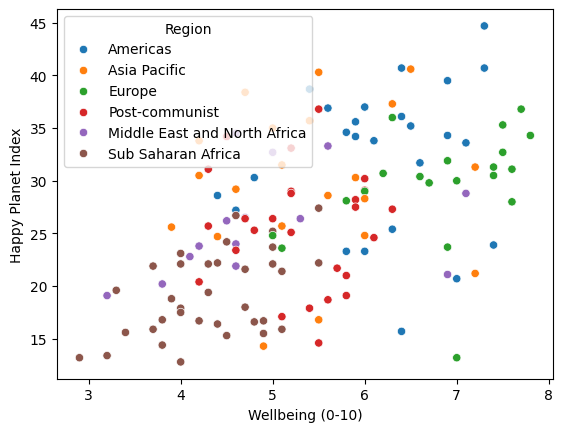

In [59]:
# Create a new figure object using Matplotlib to hold the plot
fig = plt.figure()  

ax = fig.add_subplot(111)  # Add a subplot to the figure; 111 means 1 row, 1 column, 1st subplot (full plot area)

# Create a scatter plot using Seaborn and assign it to the 'ax' object
ax = sns.scatterplot(  
    x='Wellbeing (0-10)',  # Set the x-axis to the 'Wellbeing (0-10)' column from the dataset
    y='Happy Planet Index',  # Set the y-axis to the 'Happy Planet Index' column from the dataset
    hue='Region',  # Color the points by 'Region' to show categorical grouping
    data=hpi_df  # Specify the dataset to use, which is the Happy Planet Index DataFrame
)

# Render the plot and display it in the output
plt.show()

Add `zooming`

In [60]:
# Create an Altair chart from the hpi_df DataFrame using filled circle markers
alt.Chart(hpi_df).mark_circle().encode(  
    x='Wellbeing (0-10):Q',              # Set the x-axis to the 'Wellbeing (0-10)' column; ':Q' specifies it's a quantitative variable
    y='Happy Planet Index:Q',            # Set the y-axis to the 'Happy Planet Index' column; ':Q' indicates quantitative data
    color='Region:N',                    # Use the 'Region' column to color the points; ':N' indicates a nominal (categorical) variable
).interactive()                          # Enable interactive features such as zooming and panning on the plot

alt.Chart(...)

Add `hover`

In [61]:
# Create a scatter plot from the hpi_df DataFrame using filled circle markers
alt.Chart(hpi_df).mark_circle().encode(   
    x='Wellbeing (0-10):Q',               # Set the x-axis to represent quantitative 'Wellbeing (0-10)' values
    y='Happy Planet Index:Q',             # Set the y-axis to represent quantitative 'Happy Planet Index' values
    color='Region:N',                     # Color the points based on the 'Region' column, which is a nominal (categorical) variable
    tooltip=[                             # Show a tooltip with the following fields when hovering over a point
        'Country',                        # Country name for the hovered point
        'Region',                         # Region of the country
        'Wellbeing (0-10)',               # Wellbeing score (0 to 10 scale)
        'Happy Planet Index',             # The country's Happy Planet Index score
        'Life Expectancy (years)',        # Life expectancy in years
    ]
)

alt.Chart(...)

`Hover` and `zooming`

In [62]:
# Create a scatter plot using Altair with circle markers from the hpi_df DataFrame
alt.Chart(hpi_df).mark_circle().encode(  
    x='Wellbeing (0-10):Q',              # Set the x-axis to 'Wellbeing (0-10)', a quantitative (Q) variable
    y='Happy Planet Index:Q',            # Set the y-axis to 'Happy Planet Index', also quantitative
    color='Region:N',                    # Use color to distinguish categories in 'Region', a nominal (N) variable
    tooltip=[                            # Define the fields that will be shown when hovering over a point
        'Country',                       # Show the country's name
        'Region',                        # Show the region the country belongs to
        'Wellbeing (0-10)',              # Show the wellbeing score (scale 0 to 10)
        'Happy Planet Index',            # Show the country's Happy Planet Index score
        'Life Expectancy (years)',       # Show life expectancy in years
    ]
).interactive()                          # Enable zooming and panning with the mouse (e.g., scroll to zoom)


alt.Chart(...)

`Select` and `highlight` functionality on a scatter plot

In [63]:
# define the selected_area variable to store the user's brushed selection (click-and-drag)
selected_area = alt.selection_interval()  

# create a scatter plot using Altair with circle marks based on the hpi_df dataset
alt.Chart(hpi_df).mark_circle().encode(  
    x='Wellbeing (0-10):Q',              # encode 'Wellbeing (0-10)' as a quantitative value on the x-axis
    y='Happy Planet Index:Q',            # encode 'Happy Planet Index' as a quantitative value on the y-axis
    color=alt.condition(                 # conditionally encode color based on the selected area
        selected_area,                  # if a point is within the selected area...
        'Region:N',                     # ...use its actual 'Region' value (colored by region)
        alt.value('lightgray')          # otherwise, color it light gray (muted)
    ), 
    tooltip=[                            # define the tooltips to display on hover
        'Country',                      # show country name
        'Region',                       # show region name
        'Wellbeing (0-10)',             # show wellbeing score
        'Happy Planet Index',           # show Happy Planet Index value
        'Life Expectancy (years)',      # show life expectancy
    ]
).add_params(selected_area)             # add the selected_area parameter to enable interactive brushing on the chart

alt.Chart(...)

Add hover, tooltip, select and highlight across multiple charts

In [64]:
# define an interval selection for brushing over the chart
selected_area = alt.selection_interval()  

# create a base scatter plot with circle marks
chart = alt.Chart(hpi_df).mark_circle().encode(  
    y='Happy Planet Index',                      # encode y-axis as 'Happy Planet Index' (quantitative implied)
    color=alt.condition(                         # conditionally color points based on selection
        selected_area,                           # if point is within selected area...
        'Region:N',                             # color by 'Region' (nominal)
        alt.value('lightgray')                   # else color the point light gray
    ),
    tooltip=[                                   # add tooltip with relevant info on hover
        'Country',                      # show country name
        'Region',                       # show region name
        'Wellbeing (0-10)',             # show wellbeing score
        'Happy Planet Index',           # show Happy Planet Index value
        'Life Expectancy (years)',      # show life expectancy 
    ]
).add_params(selected_area)                     # attach the selection interval to this chart for interactivity

chart1 = chart.encode(x='Wellbeing (0-10):Q')  # create first chart variant with x-axis = 'Wellbeing (0-10)' quantitative
chart2 = chart.encode(x='Life Expectancy (years):Q')  # create second chart variant with x-axis = 'Life Expectancy (years)' quantitative
chart1 | chart2  # horizontally concatenate chart1 and chart2 to display side by side

alt.HConcatChart(...)

Selection based on values of a feature using a `dropdown menu`

In [65]:
# create a dropdown selection bound to unique 'Region' values
input_dropdown = alt.binding_select(options=list(set(hpi_df.Region)))  

# create a point selection bound to the dropdown, selecting by 'Region'
selected_points = alt.selection_point(fields=['Region'], bind=input_dropdown, name='Select')  

# conditionally color points based on selection
color = alt.condition(  
    selected_points,      # if point's 'Region' matches selection...
    alt.Color('Region:N'), # color by 'Region' (nominal)
    alt.value('lightgray') # else color in light gray
)

# create scatter plot with circle marks
alt.Chart(hpi_df).mark_circle().encode(  
    x='Wellbeing (0-10):Q',              # encode x-axis as quantitative 'Wellbeing (0-10)'
    y='Happy Planet Index:Q',            # encode y-axis as quantitative 'Happy Planet Index'
    color=color,                        # apply the conditional color encoding defined above
    tooltip='Region:N'                  # show 'Region' on tooltip
).add_params(selected_points)           # add the dropdown point selection to the chart for interactivity

alt.Chart(...)

Barplot with line representing the mean of the selected bars

In [66]:
# define an interval selection limited to the x-axis (Region) for bar selection
selected_bars = alt.selection_interval(encodings=['x'])  

# create bar chart with bars representing mean values per Region
bars = (
    alt.Chart(hpi_df).mark_bar().encode(  
        x='Region:N',                     # encode x-axis with nominal 'Region' categories
        y='mean(Happy Planet Index):Q',  # encode y-axis with mean of quantitative 'Happy Planet Index'
        opacity=alt.condition(            # conditionally set opacity based on selection
            selected_bars,                # if bar is within selected interval on x-axis...
            alt.OpacityValue(1),          # fully opaque
            alt.OpacityValue(0.7)         # else slightly transparent
        ),
    )
    .properties(width=400)                 # set width of the bar chart to 400 pixels
    .add_params(selected_bars)             # add the interval selection interaction to this chart
)

# create a horizontal rule (line) with firebrick color
line = (
    alt.Chart(hpi_df).mark_rule(color='firebrick').encode(  
        y='mean(Happy Planet Index):Q',                      # encode y-position as mean 'Happy Planet Index'
        size=alt.SizeValue(3)                                # set thickness of the line to 3 pixels
    )
    .transform_filter(selected_bars)                         # filter the data to only selected bars (regions)
)

# overlay the bar chart and line chart to show mean line only for selected regions
bars + line  


alt.LayerChart(...)

Heatplot with interactive zooming

In [67]:
# create a chart using rectangle marks (heatmap-like bins)
alt.Chart(hpi_df).mark_rect().encode(                         
    alt.X('Happy Planet Index:Q', bin=True),             # bin the quantitative 'Happy Planet Index' values on the x-axis
    alt.Y('Wellbeing (0-10):Q', bin=True),               # bin the quantitative 'Wellbeing (0-10)' values on the y-axis
    alt.Color('count()',                                 # color the rectangles based on the count of data points in each bin
        scale=alt.Scale(scheme='greenblue'),             # use a 'greenblue' color scheme for the heatmap coloring
        legend=alt.Legend(title='Total Countries')       # add a legend titled 'Total Countries' for the color scale
    )
).interactive()                                          # make the chart interactive (zoom and pan enabled)

alt.Chart(...)

Dinamically linking a bar plot and a heatmap.

Static plots

In [68]:
# Merge the code to place the bar chart and heatmap side by side
# create a bar chart with bars representing counts per region
bars = alt.Chart(hpi_df).mark_bar().encode(                    
    x='Region:N',                                              # use 'Region' as nominal categorical x-axis
    y='count():Q',                                             # y-axis shows count of data points per region (quantitative)
).properties(width=350)                                        # set width of the bar chart to 350 pixels

# create a heatmap using rectangle marks
heatmap = alt.Chart(hpi_df).mark_rect().encode(              
    alt.X('Wellbeing (0-10):Q', bin=True),                     # bin 'Wellbeing (0-10)' quantitative variable on x-axis
    alt.Y('Life Expectancy (years):Q', bin=True),              # bin 'Life Expectancy (years)' quantitative variable on y-axis
    alt.Color('count()',                                        # color rectangles based on the count of records in each bin
        scale=alt.Scale(scheme='greenblue'),                   # apply 'greenblue' color scheme
        legend=alt.Legend(title='Total Countries')              # legend with title for count coloring
    )
).properties(width=350)                                        # set width of heatmap to 350 pixels

# concatenate the bar chart and heatmap horizontally (side by side)
bars | heatmap                                                

alt.HConcatChart(...)

Dynamic plots

Bars + Heatplot

In [69]:
## Heatplot with selection by Region on x-axis
# create heatmap using rectangles
heatmap = alt.Chart(hpi_df).mark_rect().encode(                   
    alt.X('Wellbeing (0-10):Q', bin=True),                         # bin and encode 'Wellbeing (0-10)' on x-axis as quantitative
    alt.Y('Life Expectancy (years):Q', bin=True),                  # bin and encode 'Life Expectancy (years)' on y-axis as quantitative
    alt.Color('count()',                                            # encode color based on count of points in each bin
        scale=alt.Scale(scheme='greenblue'),                       # apply green-blue color scheme
        legend=alt.Legend(title='Total Countries')                 # add legend with descriptive title
    )
).properties(width=350)                                            # set the chart width to 350 pixels

selected_region = alt.selection(type = 'single', encodings = ['x'])
## Place circles in the heatplot denoting the number of samples 
# add points (circles) on top of heatmap to show sample counts
circles = heatmap.mark_point().encode(                 
    alt.ColorValue('grey'),                             # set all circle colors to grey (constant value)
    alt.Size('count()',                                 # size of circles based on the count of records in each bin
        legend=alt.Legend(title='Records in Selection') # add legend describing circle sizes as records count
    )
).transform_filter(selected_region)                     # filter points to show only those within the selected region interval

## Place the bars
# create a bar chart from hpi_df data
bars = alt.Chart(hpi_df).mark_bar().encode(                  
    x='Region:N',                                            # x-axis encodes the 'Region' as nominal (categorical) data
    y='count()',                                              # y-axis shows count of records per region
    color=alt.condition(selected_region,                      # color depends on whether bar is in the selected region interval
                        alt.ColorValue("steelblue"),          # if selected, bar is colored steelblue
                        alt.ColorValue("grey"))               # otherwise, bar is colored grey
).properties(
    width=350                                                # set width of the bar chart to 350 pixels
).add_params(selected_region)                                # add interactive selection interval control to the chart

# display bar chart side-by-side with heatmap and circles layered together
bars | heatmap + circles                                     


/var/folders/hx/861ncdvn7w35qt5pmqz0hv980000gn/T/ipykernel_95029/1129670017.py:12: AltairDeprecationWarning:


Deprecated since `altair=5.0.0`. Use 'selection_point()' or 'selection_interval()' instead.
These functions also include more helpful docstrings.



alt.HConcatChart(...)

## References

Dash Python User Guide. https://dash.plotly.com/

Dash in 20 Minutes. https://dash.plotly.com/tutorial

Interactive Data Visualization with Python. https://github.com/TrainingByPackt/Interactive-Data-Visualization-with-Python 

PCA Visualization in Python. https://plotly.com/python/pca-visualization/

Plotly Express in Python. https://plotly.com/python/plotly-express/

Plotly Open Source Graphing Library for Python. https://plotly.com/python/

3 Cool Features of Python Altair. https://towardsdatascience.com/3-cool-features-of-python-altair-deb3f432cc11